# McCulloch–Pitts (MP) Neuron — Implementation Notebook

This notebook implements the **McCulloch–Pitts neuron (1943)**, a simple binary neuron model that can realize basic **logic gates** using a **threshold** rule.

**Core idea**

- Inputs are binary: $x_i \in \{0,1\}$
- Output is binary: $y \in \{0,1\}$
- Compute a weighted sum plus bias (or compare to a threshold)
- Apply a **step** (Heaviside) activation

We’ll also include the classic **inhibitory input** behavior often shown with MP neurons:

- If **any inhibitory input is 1**, the neuron **does not fire** (output 0), regardless of excitatory inputs.



## 1) Step activation and MP neuron rule

We will use:

$$
z = \sum_i w_i x_i + b
$$

$$
y =
\begin{cases}
1 & \text{if } z \ge 0 \\
0 & \text{otherwise}
\end{cases}
$$

Equivalent threshold form:

$$
\sum_i w_i x_i \ge \theta \Rightarrow y=1
$$

where $\theta$ is a threshold. We'll support both styles in code.


In [21]:
# Compatible with both Python 3 and Python 2 style printing (no f-strings)

def step(z):
    """Heaviside step function returning 0/1."""
    return 1 if z >= 0 else 0


## 2) McCulloch–Pitts neuron implementation

This implementation supports:
- **excitatory inputs**: contribute to the sum
- **inhibitory inputs**: if any inhibitory input is 1 → output is forced to 0
- either **(weights + bias)** or **(weights + threshold)** style


In [22]:
class McCullochPittsNeuron(object):
    def __init__(self, w, b=0.0, threshold=None, inhibitory_idx=None):
        self.w = list(w)
        self.b = b
        self.threshold = threshold
        self.inhibitory_idx = list(inhibitory_idx) if inhibitory_idx is not None else []

    def net_input(self, x):
        # Basic validation
        if len(x) != len(self.w):
            raise ValueError("x and w must have the same length. Got len(x)=%d, len(w)=%d" % (len(x), len(self.w)))

        # Inhibitory override: if any inhibitory input is 1 -> output must be 0
        for j in self.inhibitory_idx:
            if x[j] == 1:
                # Return a negative value so step() becomes 0
                return -1e9

        s = 0.0
        for wi, xi in zip(self.w, x):
            s += wi * xi

        if self.threshold is not None:
            # Fire if s >= threshold  <=>  s - threshold >= 0
            return s - self.threshold
        else:
            return s + self.b

    def predict(self, x):
        return step(self.net_input(x))


## 3) Helper: evaluate a neuron on all binary inputs

For 2 inputs, there are 4 patterns: (0,0), (0,1), (1,0), (1,1).  
We’ll generate a truth table for your neuron.


In [23]:
def truth_table_2(neuron):
    X = [(0,0), (0,1), (1,0), (1,1)]
    rows = []
    for x1, x2 in X:
        y = neuron.predict([x1, x2])
        rows.append((x1, x2, y))
    return rows

def print_truth_table(rows, title=None):
    if title:
        print(title)
    print("x1 x2 | y")
    print("---------")
    for x1, x2, y in rows:
        print("%d  %d  | %d" % (x1, x2, y))


## 4) Implement logic gates with an MP neuron

### AND gate
Fire only when both inputs are 1:
- weights: \([1,1]\)
- threshold: \(2\)  (since sum must be at least 2)

### OR gate
Fire when at least one input is 1:
- weights: \([1,1]\)
- threshold: \(1\)

### NAND gate
NAND is NOT(AND). Using bias style:
- weights: \([-1,-1]\)
- bias: \(1.5\)

Check:  
- if (1,1): z = -2 + 1.5 = -0.5 → 0  
- otherwise: z ≥ 0 → 1


In [24]:
# AND
and_neuron = McCullochPittsNeuron(w=[1,1], threshold=2)
print_truth_table(truth_table_2(and_neuron), title="AND gate (MP neuron)")

print()

# OR
or_neuron = McCullochPittsNeuron(w=[1,1], threshold=1)
print_truth_table(truth_table_2(or_neuron), title="OR gate (MP neuron)")

print()

# NAND
nand_neuron = McCullochPittsNeuron(w=[-1,-1], b=1.5)
print_truth_table(truth_table_2(nand_neuron), title="NAND gate (MP neuron)")


AND gate (MP neuron)
x1 x2 | y
---------
0  0  | 0
0  1  | 0
1  0  | 0
1  1  | 1

OR gate (MP neuron)
x1 x2 | y
---------
0  0  | 0
0  1  | 1
1  0  | 1
1  1  | 1

NAND gate (MP neuron)
x1 x2 | y
---------
0  0  | 1
0  1  | 1
1  0  | 1
1  1  | 0


## 5) NOT gate with a single input

NOT(x) outputs 1 when x=0, else 0.

One way:
- weight: \([-1]\)
- bias: \(0.5\)

Check:
- x=0 → z=0.5 → 1
- x=1 → z=-0.5 → 0


In [25]:
not_neuron = McCullochPittsNeuron(w=[-1], b=0.5)

for x in [0,1]:
    print("x=%d -> y=%d" % (x, not_neuron.predict([x])))


x=0 -> y=1
x=1 -> y=0


## 6) Inhibitory inputs (classic MP behavior)

Often the MP neuron is presented with:
- **excitatory** inputs: encourage firing
- **inhibitory** inputs: prevent firing if active

Example: “Fire if x1 is 1 **unless** inhibitor x2 is 1”

- Make x2 inhibitory
- Let x1 be excitatory with threshold 1
- If x2=1, output forced to 0


In [26]:
# x = [x1, x2] where x2 is inhibitory
fire_unless_inhibited = McCullochPittsNeuron(w=[1, 0], threshold=1, inhibitory_idx=[1])

print_truth_table(truth_table_2(fire_unless_inhibited), title="Fire if x1=1 unless x2 (inhibitor)=1")


Fire if x1=1 unless x2 (inhibitor)=1
x1 x2 | y
---------
0  0  | 0
0  1  | 0
1  0  | 1
1  1  | 0


## 7) Build XOR using a small MP network (2-layer construction)

One standard construction:

$$
\text{XOR}(x_1,x_2) = (x_1 \lor x_2) \land \neg(x_1 \land x_2)
$$

We’ll implement:

1) $a = OR(x_1,x_2)$  
2) $b = AND(x_1,x_2)$  
3) $c = NOT(b)$  
4) $y = AND(a,c)$


In [27]:
# XOR using: (x1 OR x2) AND NOT(x1 AND x2)

def xor_mp(x1, x2):
    # a = OR(x1, x2)
    a = or_neuron.predict([x1, x2])

    # b = AND(x1, x2)
    b = and_neuron.predict([x1, x2])

    # c = NOT(b)
    c = not_neuron.predict([b])

    # y = AND(a, c)
    y = and_neuron.predict([a, c])

    return y


# Test XOR truth table
print("x1 x2 | XOR")
print("-----------")
for x1 in [0, 1]:
    for x2 in [0, 1]:
        print("%d  %d  |  %d" % (x1, x2, xor_mp(x1, x2)))


x1 x2 | XOR
-----------
0  0  |  0
0  1  |  1
1  0  |  1
1  1  |  0


## Practice: Build XNOR using a small MP network (2-layer construction)

One standard construction:

$$
\text{XNOR}(x_1,x_2) = \neg(x_1 \lor x_2) \lor (x_1 \land x_2)
$$

Implement:

1) $a = OR(x_1,x_2)$  
2) $b = AND(x_1,x_2)$  
3) $c = NOT(a)$  
4) $y = OR(b,c)$

##8) Perceptron with non-binary inputs (Rosenblatt neuron)

The perceptron extends the McCulloch–Pitts neuron in two key ways:

Inputs can be real-valued (not just 0 or 1).

Weights and bias are learned from labeled data using an update rule.

Computation:

z = wᵀx + b

Prediction rule (step activation):

If z ≥ 0, predict ŷ = 1
If z < 0, predict ŷ = 0

Key idea:

The perceptron can learn any linearly separable binary classification problem. However, a single-layer perceptron cannot solve non-linearly separable problems such as XOR.

In [28]:
# Perceptron implementation (works with real-valued/non-binary inputs)
import numpy as np

class Perceptron(object):
    """Single-layer perceptron for binary classification.

    - Real-valued inputs allowed.
    - Labels are expected as 0/1.
    - Uses the classic perceptron learning rule.

    Parameters
    ----------
    lr : float
        Learning rate.
    epochs : int
        Number of passes over the training set.
    shuffle : bool
        Shuffle training data each epoch.
    random_state : int or None
        Seed for reproducibility.
    """
    def __init__(self, lr=0.1, epochs=50, shuffle=True, random_state=0):
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.shuffle = bool(shuffle)
        self.random_state = random_state
        self.w_ = None
        self.b_ = 0.0
        self.errors_ = []

    def _step(self, z):
        return 1 if z >= 0.0 else 0

    def net_input(self, x):
        # x: 1D array-like
        return float(np.dot(self.w_, x) + self.b_)

    def predict_one(self, x):
        return self._step(self.net_input(x))

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self.predict_one(x) for x in X], dtype=int)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)

        if X.ndim != 2:
            raise ValueError("X must be 2D of shape (n_samples, n_features)")
        if y.ndim != 1 or y.shape[0] != X.shape[0]:
            raise ValueError("y must be 1D of length n_samples")

        # initialize weights and bias
        rng = np.random.RandomState(self.random_state)
        self.w_ = rng.normal(loc=0.0, scale=0.01, size=X.shape[1]).astype(float)
        self.b_ = 0.0
        self.errors_ = []

        indices = np.arange(X.shape[0])

        for _ in range(self.epochs):
            if self.shuffle:
                rng.shuffle(indices)

            errors = 0
            for i in indices:
                xi = X[i]
                yi = int(y[i])
                yhat = self.predict_one(xi)
                update = self.lr * (yi - yhat)
                if update != 0.0:
                    self.w_ += update * xi
                    self.b_ += update
                    errors += 1
            self.errors_.append(errors)

        return self
    
    
def xnor_mp(x1, x2):
    # a = OR(x1, x2)
    a = or_neuron.predict([x1, x2])

    # b = AND(x1, x2)
    b = and_neuron.predict([x1, x2])

    # c = NOT(b)
    c = not_neuron.predict([a])

    # y = AND(a, c)
    y = or_neuron.predict([b, c])

    return y


# Test XOR truth table
print("x1 x2 | XNOR")
print("-----------")
for x1 in [0, 1]:
    for x2 in [0, 1]:
        print("%d  %d  |  %d" % (x1, x2, xnor_mp(x1, x2)))


x1 x2 | XNOR
-----------
0  0  |  1
0  1  |  0
1  0  |  0
1  1  |  1


## 9) Train a perceptron on real-valued data (example)

Below we create a simple 2D dataset with **real-valued features** and labels generated by a linear rule.
Then we train the perceptron and visualize the learned decision boundary.

(If you change the data so it's not linearly separable, the perceptron may not converge.)


In [29]:
import numpy as np

# Make a reproducible, linearly separable dataset (real-valued inputs)
rng = np.random.RandomState(7)
n = 5

X_pos = rng.randn(n//2, 2) + np.array([2.0, 2.0])
X_neg = rng.randn(n//2, 2) + np.array([-2.0, -2.0])
print(X_pos)
print(X_neg)

[[3.6905257  1.53406263]
 [2.03282016 2.40751628]]
[[-2.78892303 -1.99793443]
 [-2.00089039 -3.75472431]]


In [30]:
import numpy as np

# Make a reproducible, linearly separable dataset (real-valued inputs)
rng = np.random.RandomState(7)
n = 60

X_pos = rng.randn(n//2, 2) + np.array([2.0, 2.0])
X_neg = rng.randn(n//2, 2) + np.array([-2.0, -2.0])

X = np.vstack([X_pos, X_neg])
y = np.array([1]*(n//2) + [0]*(n//2), dtype=int)

# Train
p = Perceptron(lr=0.1, epochs=25, shuffle=True, random_state=1)
p.fit(X, y)

# Evaluate
pred = p.predict(X)
acc = (pred == y).mean()

print("Weights:", p.w_)
print("Bias:", p.b_)
print("Training accuracy:", acc)
print("Errors per epoch:", p.errors_)


Weights: [0.2227627  0.09810911]
Bias: 0.0
Training accuracy: 1.0
Errors per epoch: [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


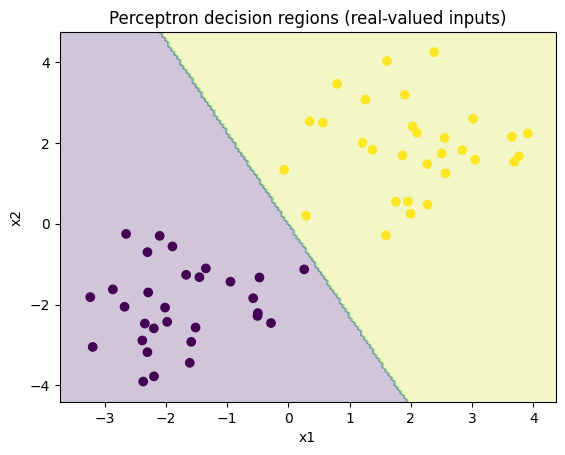

In [31]:
# Plot the decision boundary (2D only)
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary_2d(model, X, y, pad=0.5, step=0.05):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=int)

    x_min, x_max = X[:,0].min() - pad, X[:,0].max() + pad
    y_min, y_max = X[:,1].min() - pad, X[:,1].max() + pad

    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, zz, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title("Perceptron decision regions (real-valued inputs)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_boundary_2d(p, X, y)


## 10) Practice exercises (students)

**Exercise A:** Create an MP neuron for **NOR** and print its truth table.

Hint: NOR is NOT(OR).

**Exercise B:** Create an MP neuron that fires if **at least 2 out of 3** inputs are 1.

Hint: weights \([1,1,1]\), threshold \(2\).

**Exercise C:** For the neuron \(w=[2,-1],\; b=-0.5\), compute predictions for:
- \([0,0]\), \([0,1]\), \([1,0]\), \([1,1]\)


In [32]:
# Exercise A: NOR gate (fill in)
# 1) Build OR neuron
# 2) Build NOT neuron
# 3) Compose NOR = NOT(OR)

# TODO: write your code here

def nor_mp(x1, x2):
    # a = OR(x1, x2)
    a = or_neuron.predict([x1, x2])

    # y = NOT(a)
    y = not_neuron.predict([a])

    return y

def nor_truth_table():
    print("x1 x2 | NOR")
    print("-----------")
    for x1 in [0, 1]:
        for x2 in [0, 1]:
            print("%d  %d  |  %d" % (x1, x2, nor_mp(x1, x2)))

nor_truth_table()


x1 x2 | NOR
-----------
0  0  |  1
0  1  |  0
1  0  |  0
1  1  |  0


In [33]:
# Exercise B: "2 out of 3" neuron (fill in)

# TODO: write your code here
def two_out_of_three_mp(x1, x2, x3):
    two_out_of_three_neuron = McCullochPittsNeuron(w=[1, 1, 1], threshold=2)
    return two_out_of_three_neuron.predict([x1, x2, x3])

def truth_table_3():
    print("x1 x2 x3 | 2-out-of-3")
    print("-----------------------")
    for x1 in [0, 1]:
        for x2 in [0, 1]:
            for x3 in [0, 1]:
                print("%d  %d  %d  |  %d" % (x1, x2, x3, two_out_of_three_mp(x1, x2, x3)))
                
truth_table_3()




x1 x2 x3 | 2-out-of-3
-----------------------
0  0  0  |  0
0  0  1  |  0
0  1  0  |  0
0  1  1  |  1
1  0  0  |  0
1  0  1  |  1
1  1  0  |  1
1  1  1  |  1


In [34]:
# Exercise C: compute predictions (fill in)

# TODO: write your code here
def c_neuron_mp(x1, x2):
    c_neuron = McCullochPittsNeuron(w=[2,-1], b=-0.5)
    return c_neuron.predict([x1, x2])

def c_truth_table():
    print("x1 x2 | c")
    print("-----------")
    for x1 in [0, 1]:
        for x2 in [0, 1]:
            print("%d  %d  |  %d" % (x1, x2, c_neuron_mp(x1, x2)))

c_truth_table()
    

x1 x2 | c
-----------
0  0  |  0
0  1  |  0
1  0  |  1
1  1  |  1


In [35]:
# Try to get the same predictions using a single MP neuron with inhibitory input
# x1 x2 | c
# 0  0  | 1
# 0  1  | 1
# 1  0  | 0
# 1  1  | 0
# TODO: write your code here
def extra_neuron_mp(x1, x2):
    c_neuron = McCullochPittsNeuron(w=[-2,1], b=0.5)
    return c_neuron.predict([x1, x2])

def extra_truth_table():
    print("x1 x2 | c")
    print("-----------")
    for x1 in [0, 1]:
        for x2 in [0, 1]:
            print("%d  %d  |  %d" % (x1, x2, extra_neuron_mp(x1, x2)))

extra_truth_table()

x1 x2 | c
-----------
0  0  |  1
0  1  |  1
1  0  |  0
1  1  |  0


### Exercise : Classification errors + retraining (Perceptron)

In this exercise you will:

1. Create **100 positive** and **100 negative** samples (2D points).
2. Evaluate a **previously trained** perceptron model by counting **classification errors**.
3. Retrain a new perceptron on the same data and compute the errors again.

**Important:** To compute the **number of classification errors**, you must:
- predict the label for **each** sample, and
- if the predicted label does **not** match the target label, count it as **one error**.


In [36]:
# Create 100 positive and 100 negative samples (2D)
import numpy as np

np.random.seed(42)

# Positive samples centered around (2, 2)
X_pos = np.random.randn(100, 2) + 2.0
y_pos = np.ones(100, dtype=int)   # label 1

# Negative samples centered around (-2, -2)
X_neg = np.random.randn(100, 2) - 2.0
y_neg = np.zeros(100, dtype=int)  # label 0

# Combine
X_new = np.vstack([X_pos, X_neg])
y_new = np.hstack([y_pos, y_neg])

print("X_new shape:", X_new.shape)
print("y_new counts:", np.sum(y_new==1), "positive,", np.sum(y_new==0), "negative")


X_new shape: (200, 2)
y_new counts: 100 positive, 100 negative


#### Part 1 — Count errors for a previously trained model

Assume we already have a trained model with the following parameters:

- weight vector: `w_prev`
- bias: `b_prev`

Complete the function `count_errors_step()` to compute the **number of classification errors** on `(X_new, y_new)`.


In [37]:
# Previously trained model parameters (given)
w_prev = np.array([0.5, 0.5], dtype=float)
b_prev = 0.0

def step(z):
    """Perceptron step function: returns 1 if z>=0 else 0."""
    return 1 if z >= 0.0 else 0

def count_errors_step(X, y, w, b):
    """Count classification errors by predicting each sample and comparing to target."""
    errors = 0

    for i in range(len(X)):
        # TODO 1: compute activation z = w·x + b
        z = np.dot(w, X[i]) + b

        # TODO 2: compute predicted label using step(z)
        y_hat = step(z)

        # TODO 3: if prediction mismatches target, increment errors
        if y_hat != y[i]:
            errors += 1

    return errors

# TODO 4: call count_errors_step(...) and print the number of errors for the previously trained model
prev_errors = count_errors_step(X, y, w_prev, b_prev)
print("Errors for previously trained model:", prev_errors)


Errors for previously trained model: 0


#### Part 2 — Retrain the perceptron on the new data and count errors again

Now retrain a perceptron using the `Perceptron` class defined earlier in this notebook.

Complete the code to:
1. Create a new perceptron instance
2. Fit it on `(X_new, y_new)`
3. Compute the number of errors on the **same** `(X_new, y_new)`


In [38]:
# TODO 5: create and train a new perceptron on (X_new, y_new)
# Hint: labels are 0/1, which matches the Perceptron class in this notebook.
p = Perceptron(lr=0.1, epochs=25, shuffle=True, random_state=1)
p.fit(X_new, y_new)


# TODO 6: use model.predict(X_new) to get predictions
y_pred = p.predict(X_new)

# TODO 7: count errors by comparing y_pred with y_new
retrain_errors = np.sum(y_pred != y_new)
print("Errors after retraining:", retrain_errors)


Errors after retraining: 0


Errors on random data: 47


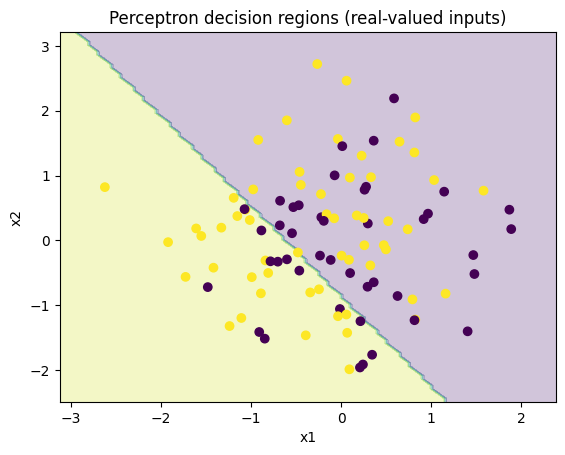

In [39]:
def create_random_data():
    """Create a random dataset of 100 samples with 2 features and binary labels."""
    rng = np.random.RandomState(42)
    X_random = rng.randn(100, 2)  # 100 samples, 2 features
    y_random = rng.randint(0, 2, size=100)  # Binary labels (0 or 1)
    return X_random, y_random

p_random = Perceptron(lr=0.1, epochs=25, shuffle=True, random_state=1)
X_random, y_random = create_random_data()
p_random.fit(X_random, y_random)

y_random_pred = p_random.predict(X_random)
random_errors = np.sum(y_random_pred != y_random)
print("Errors on random data:", random_errors)

plot_decision_boundary_2d(p_random, X_random, y_random)




## After completing the practice questions, upload the notebook in the moodle.